In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score
os.chdir(os.getcwd()[:-5])

In [2]:
mlp_test = pd.read_csv('resuts/MLP_test_result.csv')

In [5]:
class Format:
    end = '\033[0m'
    underline = '\033[4m'
    bold = '\033[1m'

def classify_predictions(row, pred_column):
    
    if row[pred_column] == row['Negation_cue']:
        
        if row[pred_column] == 'O':
            return 'TN'
        return 'TP'
    
    if row[pred_column] in ['B-NEG', 'I-NEG']:
        return 'FP'
    
    return 'FN'

def construct_sentence(df, pred_column):
    sentence = ''
    df = df.reset_index(drop=True)
    for i, token in enumerate(df.Token):
        
        error_type = df.loc[i, 'class']
        
        if error_type == 'FN':
            sentence += ' ' + Format.bold + token + Format.end
        elif error_type == 'FP':
            sentence += ' ' + Format.underline + token + Format.end
        elif error_type == 'TP':
            sentence += ' ' + Format.bold + Format.underline + token + Format.end
        else:
            if token in ['.', ',', '?', '!']:
                sentence += token
            else:
                sentence += f' {token}'
    
    return sentence[1:]

def print_error(df, error, pred_column):
    
    error = df[df['class'] == error]
    error_trigram = error.trigram.values[0]
    print('Error:', Format.underline, error_trigram, Format.end, '\t',
         f'Predicted: {error[pred_column].values[0]}; Actual: {error.Negation_cue.values[0]}')
    
    sentence = construct_sentence(df, pred_column)
    print(sentence, '\n')
    
def print_errors(df, pred_column):
    
    df['class'] = df.apply(classify_predictions, args=(pred_column,), axis=1)
    
    FP_sentences = df[df['class'] == 'FP'].idx_sent.values
    FN_sentences = df[df['class'] == 'FN'].idx_sent.values
    
    print('F1-score:  ', Format.bold, round(f1_score(df.Negation_cue, df[pred_column], average='weighted', zero_division=0),4), Format.end)
    print('Precision: ', Format.bold, round(precision_score(df.Negation_cue, df[pred_column], average='weighted'),4), Format.end)
    print('Recall:    ', Format.bold, round(recall_score(df.Negation_cue, df[pred_column], average='weighted'),4), Format.end, '\n')
    
    print('Number of False Positives:', Format.bold, len(FP_sentences), Format.end)
    print('Number of False Negatives:', Format.bold, len(FN_sentences), Format.end, '\n\n')
    
    print(Format.bold + 'False Positives' + Format.end, '\n')
    for sentence_id in FP_sentences:
        print_error(df[df.idx_sent == sentence_id], 'FP', pred_column)
    
    print('\n\n', Format.bold + 'False Negatives' + Format.end, '\n')
    for sentence_id in FN_sentences:
        print_error(df[df.idx_sent == sentence_id], 'FN', pred_column)

def print_confusion_matrix(prediction, actual):
    confusion_matrix = pd.crosstab(actual, prediction, rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True)
    plt.suptitle('Confusion matrix')
    plt.savefig('CM_MLP.pdf', bbox_inches='tight')
    plt.show()

def error_analysis(df, pred_column):
    
    print('\t\t', Format.bold, 'ERROR ANALYSIS', Format.end, '\n\n')
    print_confusion_matrix(df[pred_column], df.Negation_cue)
    print_errors(df, pred_column)

		  ERROR ANALYSIS  




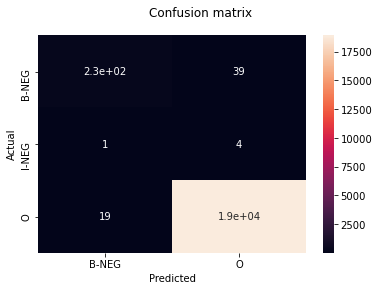

F1-score:    0.9965 
Precision:   0.9964 
Recall:      0.9967  

Number of False Positives:  20 
Number of False Negatives:  43  


False Positives 

Error:  Why not write  	 Predicted: B-NEG; Actual: O
Why not write? At two o'clock yesterday afternoon a small packet, wrapped in brown paper, was handed in by the postman. 

Error:  absolutely nothing ?  	 Predicted: B-NEG; Actual: I-NEG
Do you say nothing has come out of that room -- absolutely nothing? " " So I shall, Miss Cushing. 

Error:  nothing rash .  	 Predicted: B-NEG; Actual: O
Do nothing rash. She told us many details about her brother-in-law the steward, and then wandering off on the subject of her former lodgers, the medical students, she gave us a long account of their delinquencies, with their names and those of their hospitals. 

Error:  is n't it  	 Predicted: B-NEG; Actual: O
" Danger, " is n't it? In accordance with the scheme which we had formed in order to test our theories " [ " the " we " is rather fine, Watson, i

C:\Users\StanvanLoon\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
error_analysis(mlp_test, 'pred_MLP')